### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor

from statsmodels.stats.stattools import durbin_watson

from scipy import stats
from scipy.special import inv_boxcox

### Read data

In [3]:
df = pd.read_csv("../data/car data.csv")

In [4]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


`Selling_Price` will be the Y , and  the remain features are the independent variables

In [5]:
df.shape

(301, 9)

In [6]:
df.describe(include="number")

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


### Data preparation

In [7]:
df["Car_Name"].nunique()

98

Since Car_Name contains 98 categories, and this number of categories is very high compared to thenumber of dataset samples, it is better to drop it :

In [8]:
df.drop("Car_Name",axis=1, inplace=True)

In [10]:
## Feature transformation

df.insert(0, "Age", df["Year"].max()+1-df["Year"])
df.drop("Year", axis=1, inplace=True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


#### Outliers detection

An outlier is a data point that differs significantly from other observations.They can cause the performance of the model to drop. We use boxplot to detect oultiers:
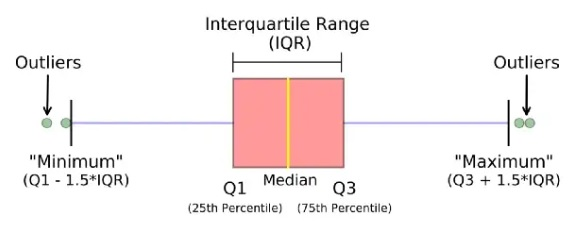

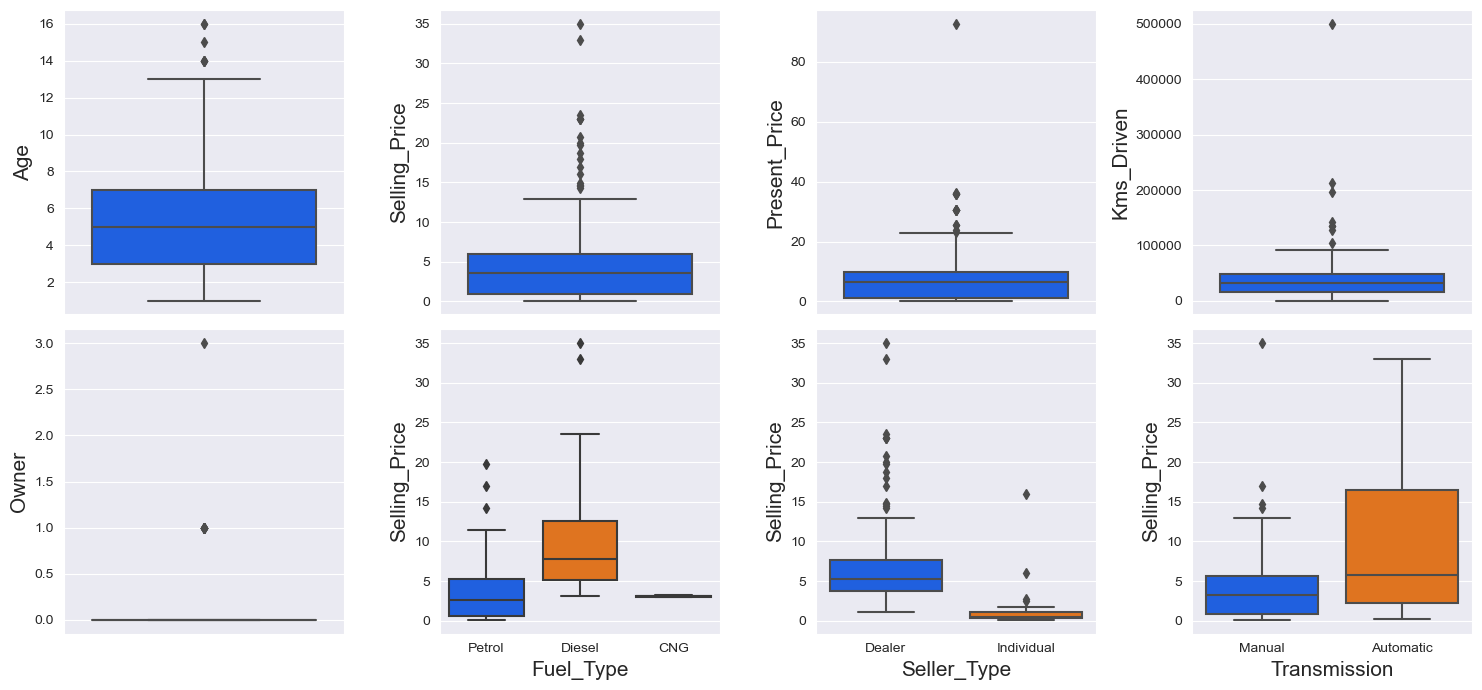

In [12]:
sns.set_style("darkgrid")
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
OrderedCols = np.concatenate([df.select_dtypes(exclude="object").columns.values, df.select_dtypes(include="object").columns.values])

fig, ax = plt.subplots(2,4, figsize=(15,7), dpi=100)

for i , col in enumerate(OrderedCols):
    x = i//4
    y = i%4
    if i < 5:
        sns.boxplot(data=df, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, x=col, y="Selling_Price", ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)
plt.tight_layout()
plt.show()

We can see from the boxplots above, there are outliers in the dataset. We will identify the outliers based on the InterQuartile Range rule:

In [15]:
outliers_indexes = []
target = "Selling_Price"

for col in df.select_dtypes(include="object").columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat ]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())


for col in df.select_dtypes(exclude="object").columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
outliers_indexes = list(set(outliers_indexes))
print("{} outliers were identified, whose indices are: \n\n{}".format(len(outliers_indexes), outliers_indexes))


20 outliers were identified, whose indices are: 

[27, 50, 51, 52, 53, 54, 59, 62, 63, 64, 66, 69, 79, 80, 82, 85, 86, 93, 96, 97]


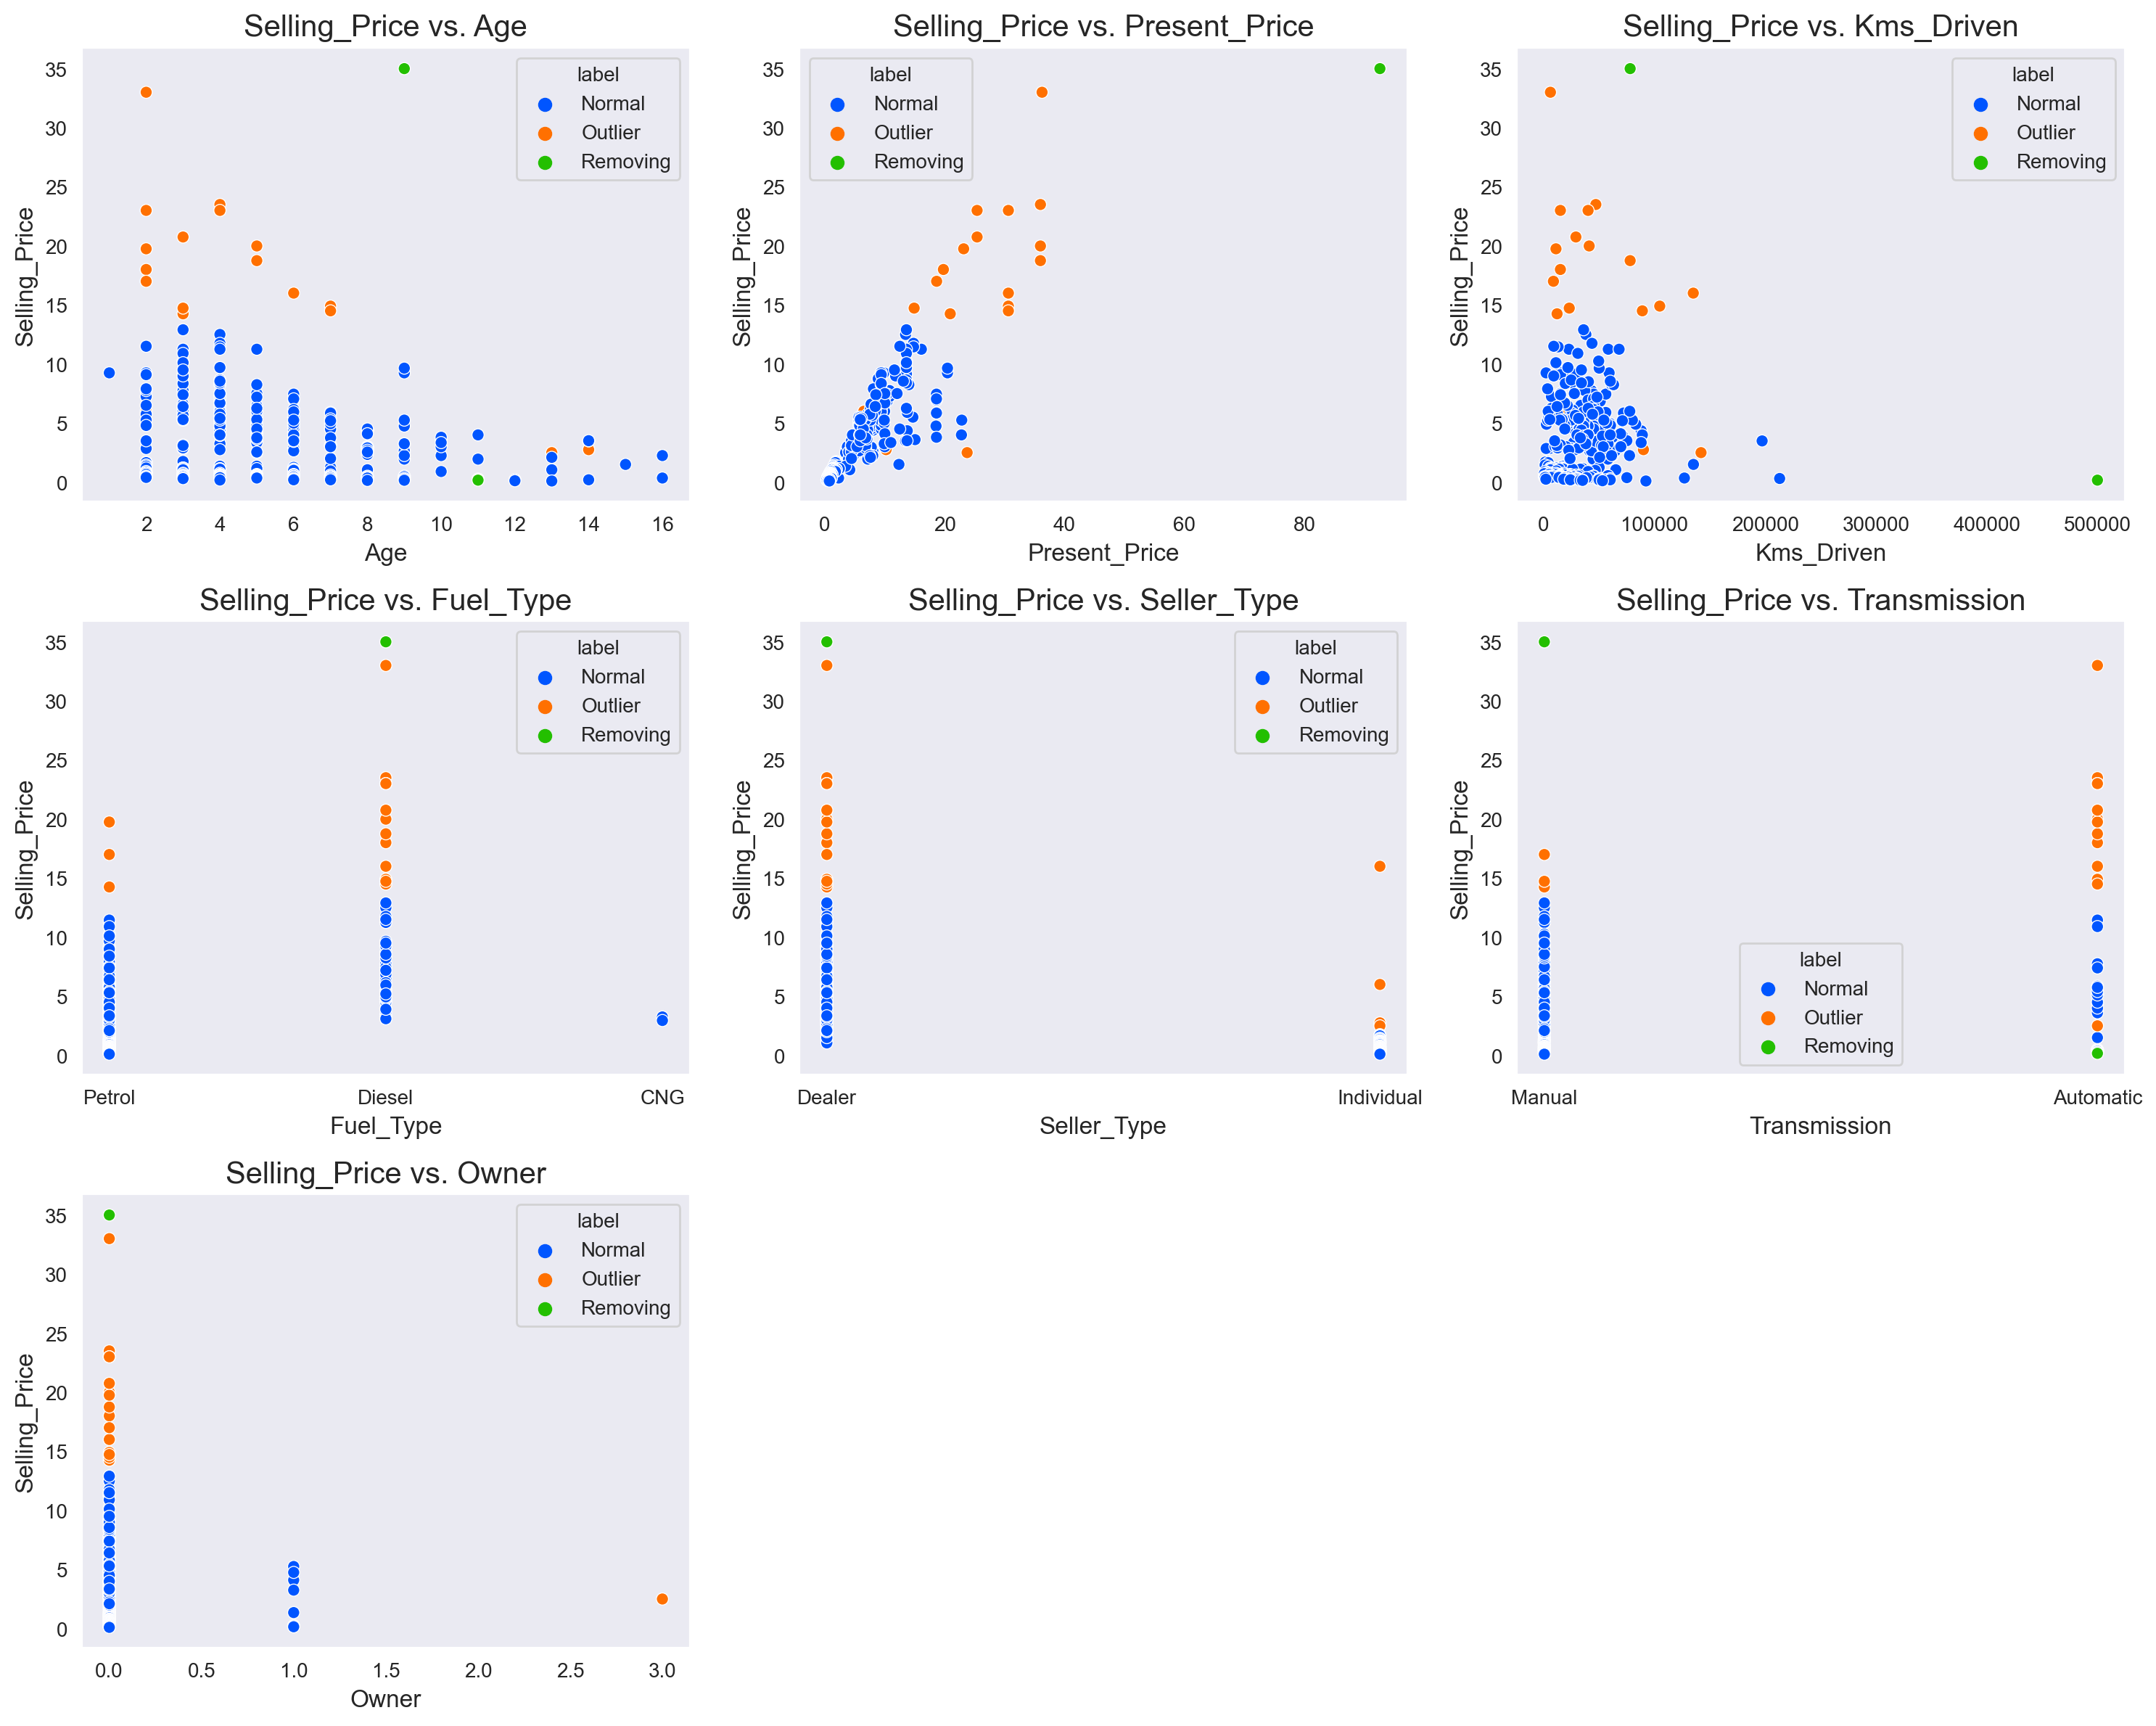

In [16]:
## Outliers labeling

df1 = df.copy()
df1["label"] = "Normal"
df1.loc[outliers_indexes, "label"] = "Outlier"

## Removing Outliers

removing_indexes = []
removing_indexes.extend(df1[df1[target] > 33].index)
removing_indexes.extend(df1[df1["Kms_Driven"]> 400000].index)
df1.loc[removing_indexes, "label"] = "Removing"

## Plot

target = "Selling_Price"
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
customPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x = i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue="label", ax=ax[x,y])
    ax[x,y].set_title("{} vs. {}".format(target, features[i]), size= 15)
    ax[x,y].set_xlabel(features[i], size=12)
    ax[x,y].set_ylabel(target, size=12)
    ax[x,y].grid()



ax[2,1].axis("off")
ax[2,2].axis("off")
plt.tight_layout()
plt.show()

The outliers to be removed will be related to the following indexes

In [17]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

These 2 samples are quite different from the general pattern found in scatter plots of the data. Since Linear Regression is sensitive to outliers, we will drop them

### Discover Missing values 

In [18]:
df.isna().sum()

Age              0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

#### Duplicates

In [19]:
df[df.duplicated(keep=False)]

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
15,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0


#### Drop Outliers

In [20]:
df1 = df.copy()

df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

### Now it's time for the EDA (exploratory Data analysis)

#### - Categorical variables Univariate analysis

## **<font color="red">stop here</font>**